In [3]:
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import functions as func

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150

## Load & Infos sur le DF

In [4]:
df = pd.read_csv('../data/data.csv')

/tmp/ipykernel_22285/785670083.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/data.csv')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

## Transforme les str en float ($)

In [6]:
cols = ['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']
for c in cols:
    df[c] = df[c].apply(lambda x: func.dol_to_float(x))

## Encode les dates en datetime pd

In [7]:
for c in ['ApprovalDate','ChgOffDate', 'DisbursementDate']:
    df[c] = df[c].loc[df[c].notnull()].apply(lambda x: func.month_l_to_n(str(x)))
    df[c] = pd.to_datetime(df[c])

## Transforme les manquants en NaN

In [8]:
for c in ["NAICS", "Zip", "Term", "NoEmp"]:
    if c == "Zip":
        df[c] = df[c].apply(lambda x: None if len(str(x)) < 5 else str(x))
    else:
        df[c] = df[c].apply(lambda x: None if x == 0 else x)

## Créer / Recreer les columns au bon format

In [9]:
df['is_default'] = df['MIS_Status'].apply(lambda x: func.in_default(x))
df["have_franchise"] = df['FranchiseCode'].apply(lambda x: 0 if x == 0 | x == 1 else 1)
df['sector'] = df['NAICS'].apply(lambda x: func.get_sector(str(x)))
df['UrbanRural'] = df['UrbanRural'].apply(lambda x: func.urban_or_rural(x))
df['NewExist'] = df['NewExist'].apply(lambda x: func.is_new(x))
df['LowDoc'] = df['LowDoc'].apply(lambda x: func.is_lowdoc(x))
df['RevLineCr'] = df['RevLineCr'].apply(lambda x: func.is_renouvelable(x))

start_period = pd.to_datetime("2007-12-01")
end_period = pd.to_datetime("2009-06-30")

df['in_recession'] = (df['ApprovalDate'] >= start_period) & (df['ApprovalDate'] <= end_period)
df['in_recession'] = df['in_recession'].apply(lambda x: 1 if x else 0)

## Columns après transformation

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   LoanNr_ChkDgt      899164 non-null  int64         
 1   Name               899150 non-null  object        
 2   City               899134 non-null  object        
 3   State              899150 non-null  object        
 4   Zip                804574 non-null  object        
 5   Bank               897605 non-null  object        
 6   BankState          897598 non-null  object        
 7   NAICS              697216 non-null  float64       
 8   ApprovalDate       899164 non-null  datetime64[ns]
 9   ApprovalFY         899164 non-null  object        
 10  Term               898354 non-null  float64       
 11  NoEmp              892533 non-null  float64       
 12  NewExist           897994 non-null  object        
 13  CreateJob          899164 non-null  int64   

## Nettoyage

### Suppression des NaN

In [11]:
df_test = df.drop(columns=['LoanNr_ChkDgt', 'Name', "Zip", "NAICS", "ApprovalDate", 'ApprovalFY', 'FranchiseCode', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross', 'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'SBA_Appv', 'Bank'], axis=1)

<AxesSubplot: >

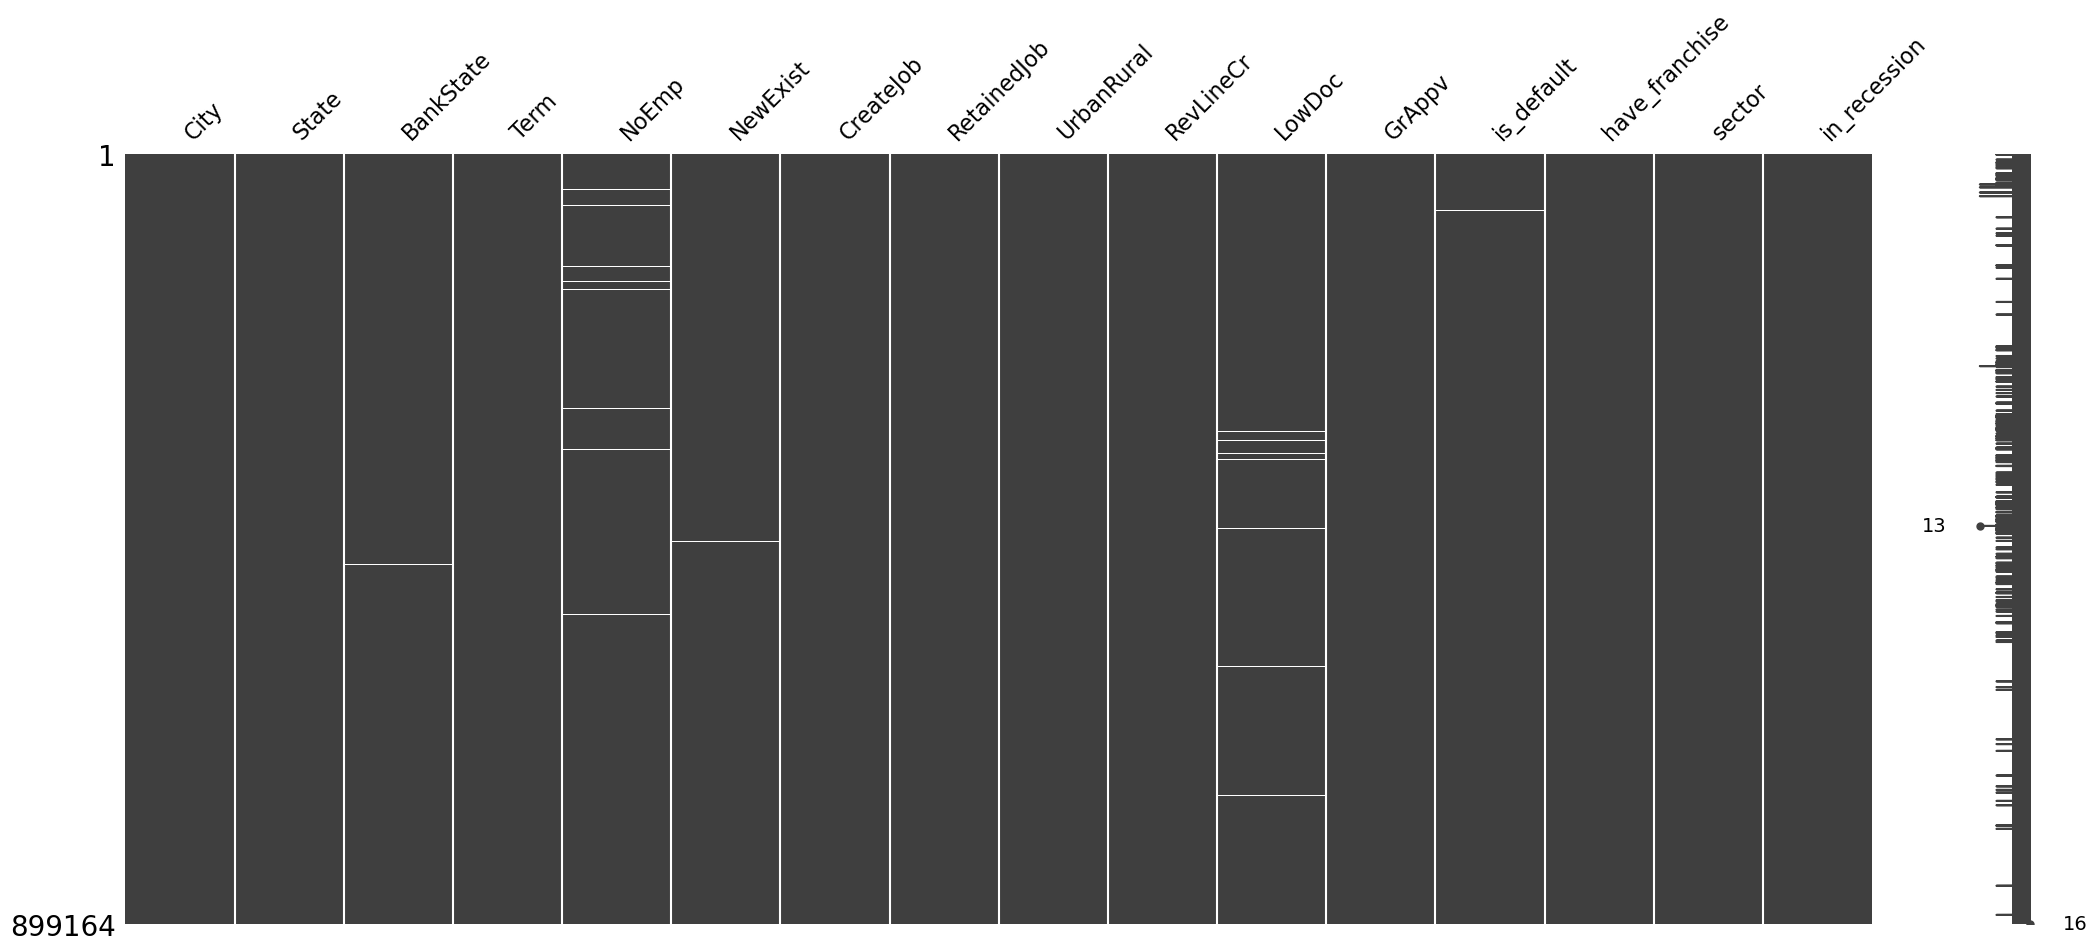

In [12]:
msno.matrix(df_test)

<AxesSubplot: >

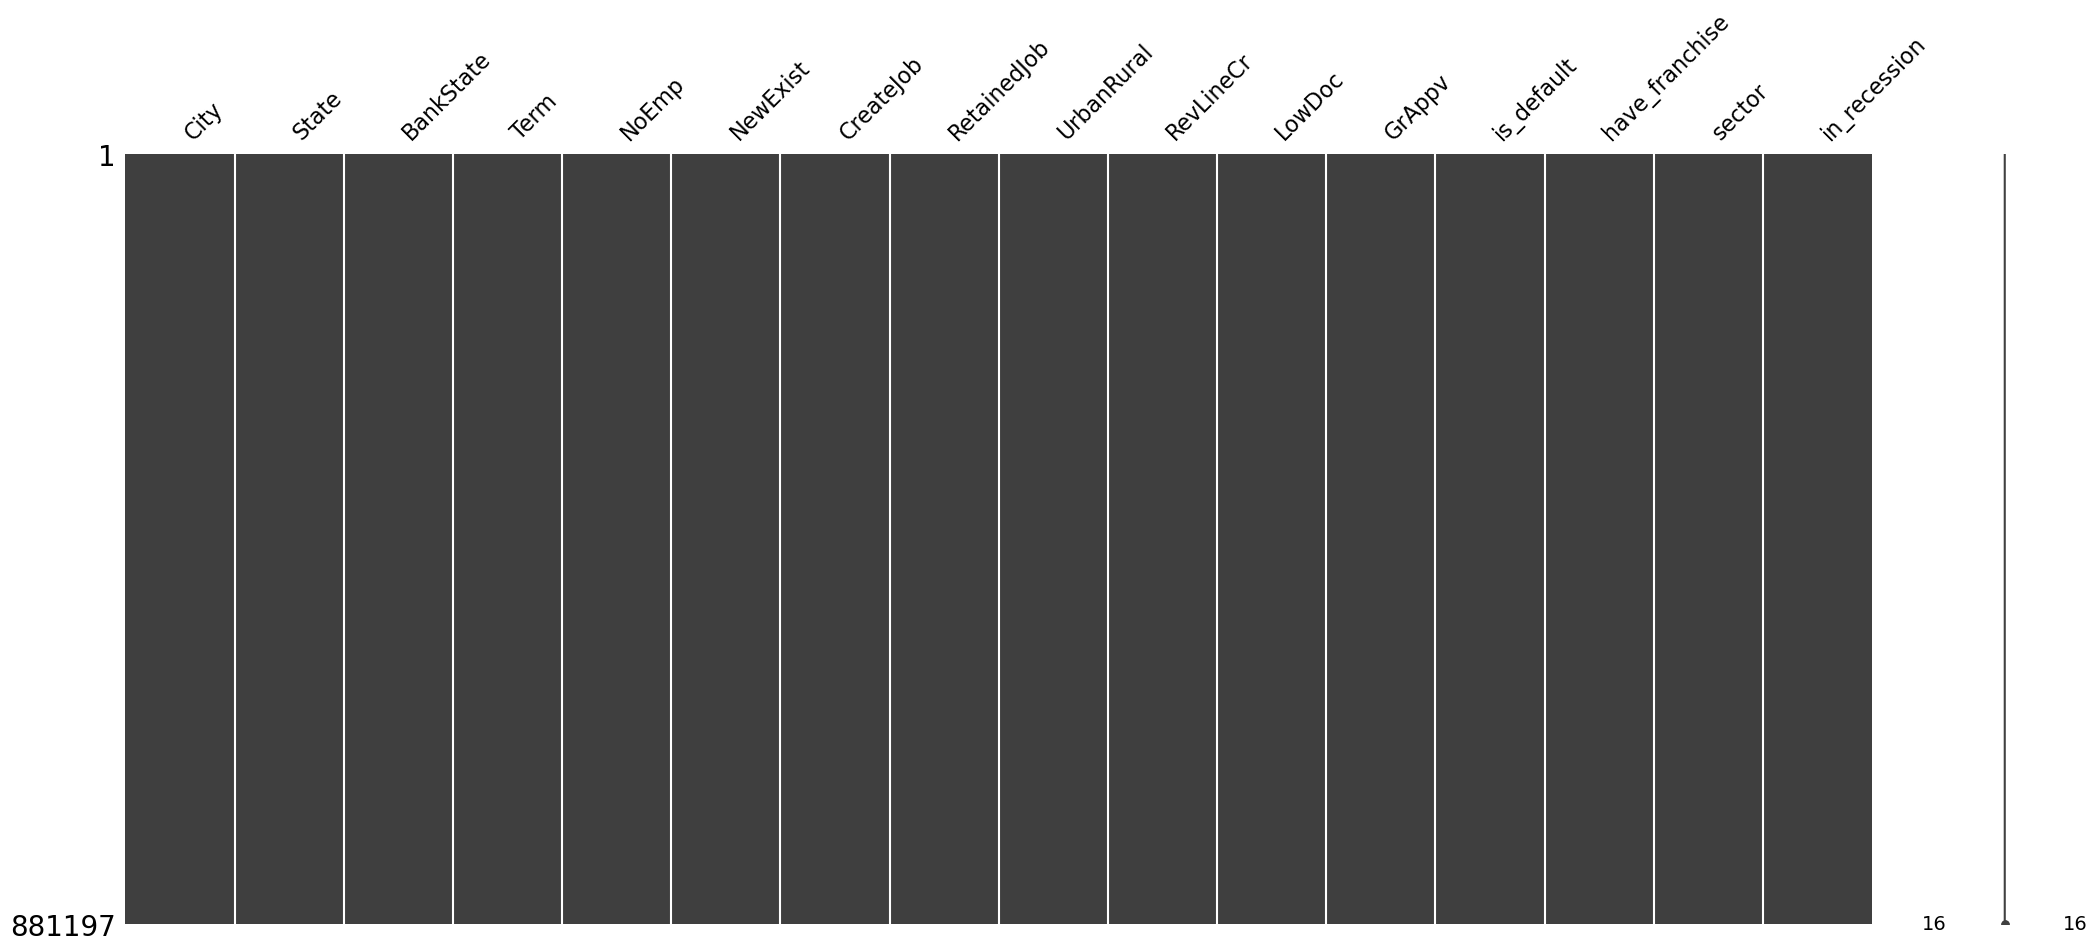

In [13]:
df_test = df_test.dropna(axis=0)
msno.matrix(df_test)

## Genere un rapport

In [14]:
# # Encodage INT
df_test[['LowDoc', 'is_default']] = df_test[['LowDoc', 'is_default']].astype(int)

In [15]:
# # Optimisation
# df_test[['have_franchise', 'is_default', 'RevLineCr','LowDoc', 'in_recession']] = df_test[['in_recession', 'have_franchise','is_default', 'RevLineCr','LowDoc']].astype(np.int8)

### Sweetviz

In [16]:
# import sweetviz as sv

# my_report = sv.analyze(df_test)
# my_report.show_html()

### Profiling

In [17]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_test, title="Pandas Profiling Report")
profile.to_file(output_file='rapport.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/home/apprenant/miniconda3/envs/assurance/lib/python3.9/site-packages/multimethod/__init__.py:315: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  return func(*args, **kwargs)


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
df_test.to_csv("../data/data_clear.csv",index=False)